In [1]:
from PIL import ImageFile
from copy import deepcopy

import datasets
import json
import numpy as np
import os
import pandas as pd
import torch
import transformers

import torch.nn as nn
from typing import Dict, Union, Any, Optional, List, Tuple
from detr import CocoEvaluator

In [2]:
class HolyTrainer(transformers.Trainer):
    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:
        """
        Perform an evaluation step on `model` using `inputs`.

        Subclass and override to inject custom behavior.

        Args:
            model (`nn.Module`):
                The model to evaluate.
            inputs (`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument `labels`. Check your model's documentation for all accepted arguments.
            prediction_loss_only (`bool`):
                Whether or not to return the loss only.
            ignore_keys (`Lst[str]`, *optional*):
                A list of keys in the output of your model (if it is a dictionary) that should be ignored when
                gathering predictions.

        Return:
            Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]: A tuple with the loss,
            logits and labels (each being optional).
        """
        has_labels = all(inputs.get(k) is not None for k in self.label_names)
        inputs = self._prepare_inputs(inputs)
        if ignore_keys is None:
            if hasattr(self.model, "config"):
                ignore_keys = getattr(self.model.config, "keys_to_ignore_at_inference", [])
            else:
                ignore_keys = []

        # labels may be popped when computing the loss (label smoothing for instance) so we grab them first.
        if has_labels:
            labels = inputs['labels']
#             labels = nested_detach(tuple(inputs.get(name) for name in self.label_names))
#             if len(labels) == 1:
#                 labels = labels[0]
        else:
            labels = None

        with torch.no_grad():
            if has_labels:
                with self.compute_loss_context_manager():
                    loss, outputs = self.compute_loss(model, inputs, return_outputs=True)
                loss = loss.mean().detach()

                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys + ["loss"])
                else:
                    logits = outputs[1:]
            else:
                loss = None
                with self.compute_loss_context_manager():
                    outputs = model(**inputs)
                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys)
                else:
                    logits = outputs
                # TODO: this needs to be fixed and made cleaner later.
                if self.args.past_index >= 0:
                    self._past = outputs[self.args.past_index - 1]

        if prediction_loss_only:
            return (loss, None, None)

        logits = transformers.trainer_pt_utils.nested_detach(logits)
        if len(logits) == 1:
            logits = logits[0]

        return (loss, logits, labels)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
ImageFile.LOAD_TRUNCATED_IMAGES = True

RANDOM_SEED = 42

def set_all_seeds(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(RANDOM_SEED)

In [4]:
model_name_or_path = "facebook/detr-resnet-50"

In [5]:
public_bbox = json.loads(open("./simmc2/data/public/cloth_store_1_1_1_bbox.json").read())
public_bbox["Items"][0]

{'name': 'sneakers_2(Clone)',
 'prefabPath': 'clothing_store/models/prefab/sneakers_2',
 'bbox': [1178, 564, 29, 22],
 'position': [-3.576437473297119, 0.03797276318073273, 2.1606364250183105]}

In [6]:
public_scene = json.loads(open("./simmc2/data/public/cloth_store_1_1_1_scene.json").read())
public_scene["scenes"][0]["objects"]

[{'prefab_path': '1208725/Jacket_blue',
  'unique_id': 0,
  'index': 0,
  'bbox': [1303, 88, 218, 153],
  'position': [-2.866098403930664, 0.05314898490905762, 1.6969716548919678]},
 {'prefab_path': '1208725/Jacket_blue',
  'unique_id': 0,
  'index': 1,
  'bbox': [1916, 21, 289, 181],
  'position': [-1.1282265186309814, 0.05314898490905762, 2.7818620204925537]},
 {'prefab_path': 'MensCollection/Prefabs/Rearranged/polo shirt 18',
  'unique_id': 1,
  'index': 2,
  'bbox': [947, 166, 139, 54],
  'position': [-5.126088619232178, 1.8119479417800903, 2.2323215007781982]},
 {'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_3_06',
  'unique_id': 2,
  'index': 3,
  'bbox': [1045, 132, 182, 39],
  'position': [-6.755237102508545, -0.7599018812179565, 4.868677139282227]},
 {'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_2_06',
  'unique_id': 3,
  'index': 4,
  'bbox': [1065, 156, 148, 20],
  'position': [-6.0655694007873535, -2.101559638977051, -1.9722471237182617]},
 {'prefab_p

In [7]:
fashion_prefab = json.loads(open("./simmc2/data/furniture_prefab_metadata_all.json").read())
fashion_prefab["modified_wayfair_assets/EndTable/EndTable_ATGR2663_v6_LOD2"]

{'brand': 'North Lodge',
 'color': 'black',
 'customerRating': 3.7,
 'materials': 'wood',
 'price': '$549',
 'type': 'EndTable'}

In [8]:
fashion_prefab = json.loads(open("./simmc2/data/fashion_prefab_metadata_all.json").read())
fashion_prefab["MensCollection/Prefabs/Rearranged/jacket_3_06"]

{'assetType': 'jacket_hanging',
 'customerReview': 4.8,
 'availableSizes': ['XL', 'S', 'M', 'XXL'],
 'color': 'blue',
 'pattern': 'plain',
 'brand': 'Global Voyager',
 'sleeveLength': 'full',
 'type': 'jacket',
 'price': 39.99,
 'size': 'S'}

In [9]:
def load_categories(
    fashion_prefab_path="./simmc2/data/fashion_prefab_metadata_all.json",
    furniture_prefab_path="./simmc2/data/furniture_prefab_metadata_all.json",
    return_simple_mapping=True):
    
    fashion_prefab = json.loads(open(fashion_prefab_path).read())
    furniture_prefab = json.loads(open(furniture_prefab_path).read())
    
    categories = []
    fashion_categories = list(set([fashion_prefab[item]["type"] for item in fashion_prefab]))
    furniture_categories = list(set([furniture_prefab[item]["type"] for item in furniture_prefab]))
    category_mapping = {}
    
    for i in range(len(fashion_categories)):
        categories.append({
            "supercategory": "fashion",
            "id": i,
            "name": fashion_categories[i],
        })
            
        
    current_num_categories = len(categories)
    for i in range(len(furniture_categories)):
        categories.append({
            "supercategory": "furniture",
            "id": i,
            "name": furniture_categories[i],
        })
        
    if return_simple_mapping:
        id2cat = dict(enumerate(fashion_categories + furniture_categories))
        cat2id = {v: k for k, v in id2cat.items()}
        return {"categories": categories, "id2cat": id2cat, "cat2id": cat2id}
    
    return categories

In [10]:
MAPPING = load_categories()

In [11]:
def load_objects_in_scenes_dataset(
    img_dir_paths=[
        "./simmc2/data/simmc2_scene_images_dstc10_public_part1",
        "./simmc2/data/simmc2_scene_images_dstc10_public_part2"],
    scene_dir_path="./simmc2/data/public",
    fashion_prefab_path="./simmc2/data/fashion_prefab_metadata_all.json",
#     include_fashion_attrs=["type", "color", "pattern", "sleeveLength"],
    furniture_prefab_path="./simmc2/data/furniture_prefab_metadata_all.json",
#     include_furniture_attrs=["type", "color", "materials"],
    mapping=MAPPING,
    ):
    
    data_dict = {
        "image": [], "image_id": [], "objects": []}
    
    fashion_prefab = json.loads(open(fashion_prefab_path).read())
    furniture_prefab = json.loads(open(furniture_prefab_path).read())
    scene2id = {}
    
    for img_dir_path in img_dir_paths:
        
        for img_file_id in os.listdir(img_dir_path):
            img_file_path = os.path.join(img_dir_path, img_file_id)
            scene_id = img_file_id.split(".")[0]                
            scene_file_path = os.path.join(scene_dir_path, f"{scene_id}_scene.json")
            
            if os.path.isfile(scene_file_path):
                data_dict["image"].append(img_file_path)
                num_scenes = len(data_dict["image_id"])
                scene2id[scene_id] = num_scenes
                data_dict["image_id"].append(num_scenes)
                
                scene_json = json.loads(open(scene_file_path).read())
                scene_objects = scene_json["scenes"][0]["objects"]
                objects = []
                for scene_object in scene_objects:
                    object_annotation = {
                        "bbox": [float(b) for b in scene_object["bbox"]],
                        "id": scene_object["unique_id"],
                        "area": None,
                        "segmentation": [],
                        "iscrowd": False,
                    }
                    if fashion_prefab.get(scene_object["prefab_path"]) is not None:
#                         for f_attr in include_fashion_attrs:
#                             object_annotation[f_attr] = fashion_prefab[scene_object["prefab_path"]][f_attr]
                        item = fashion_prefab[scene_object["prefab_path"]]
                    else:
                        item = furniture_prefab[scene_object["prefab_path"]]
                    object_annotation["category_id"] = mapping["cat2id"][item["type"]]
                    objects.append(object_annotation)
                data_dict["objects"].append(objects)
            
    dataset = datasets.Dataset.from_dict(data_dict)
    dataset = dataset.cast_column("image", datasets.Image(decode=True))
    
    id2scene = {v: k for k, v in scene2id.items()}
    mapping["scene2id"] = scene2id
    mapping["id2scene"] = id2scene
    
    return dataset, mapping

In [12]:
dataset, MAPPING = load_objects_in_scenes_dataset()

In [13]:
dataset.train_test_split(0.2)

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'objects'],
        num_rows: 924
    })
    test: Dataset({
        features: ['image', 'image_id', 'objects'],
        num_rows: 232
    })
})

In [33]:
dataset[0]["objects"][0]

{'area': None,
 'bbox': [198.0, 139.0, 212.0, 127.0],
 'category_id': 3,
 'id': 0,
 'iscrowd': False,
 'segmentation': []}

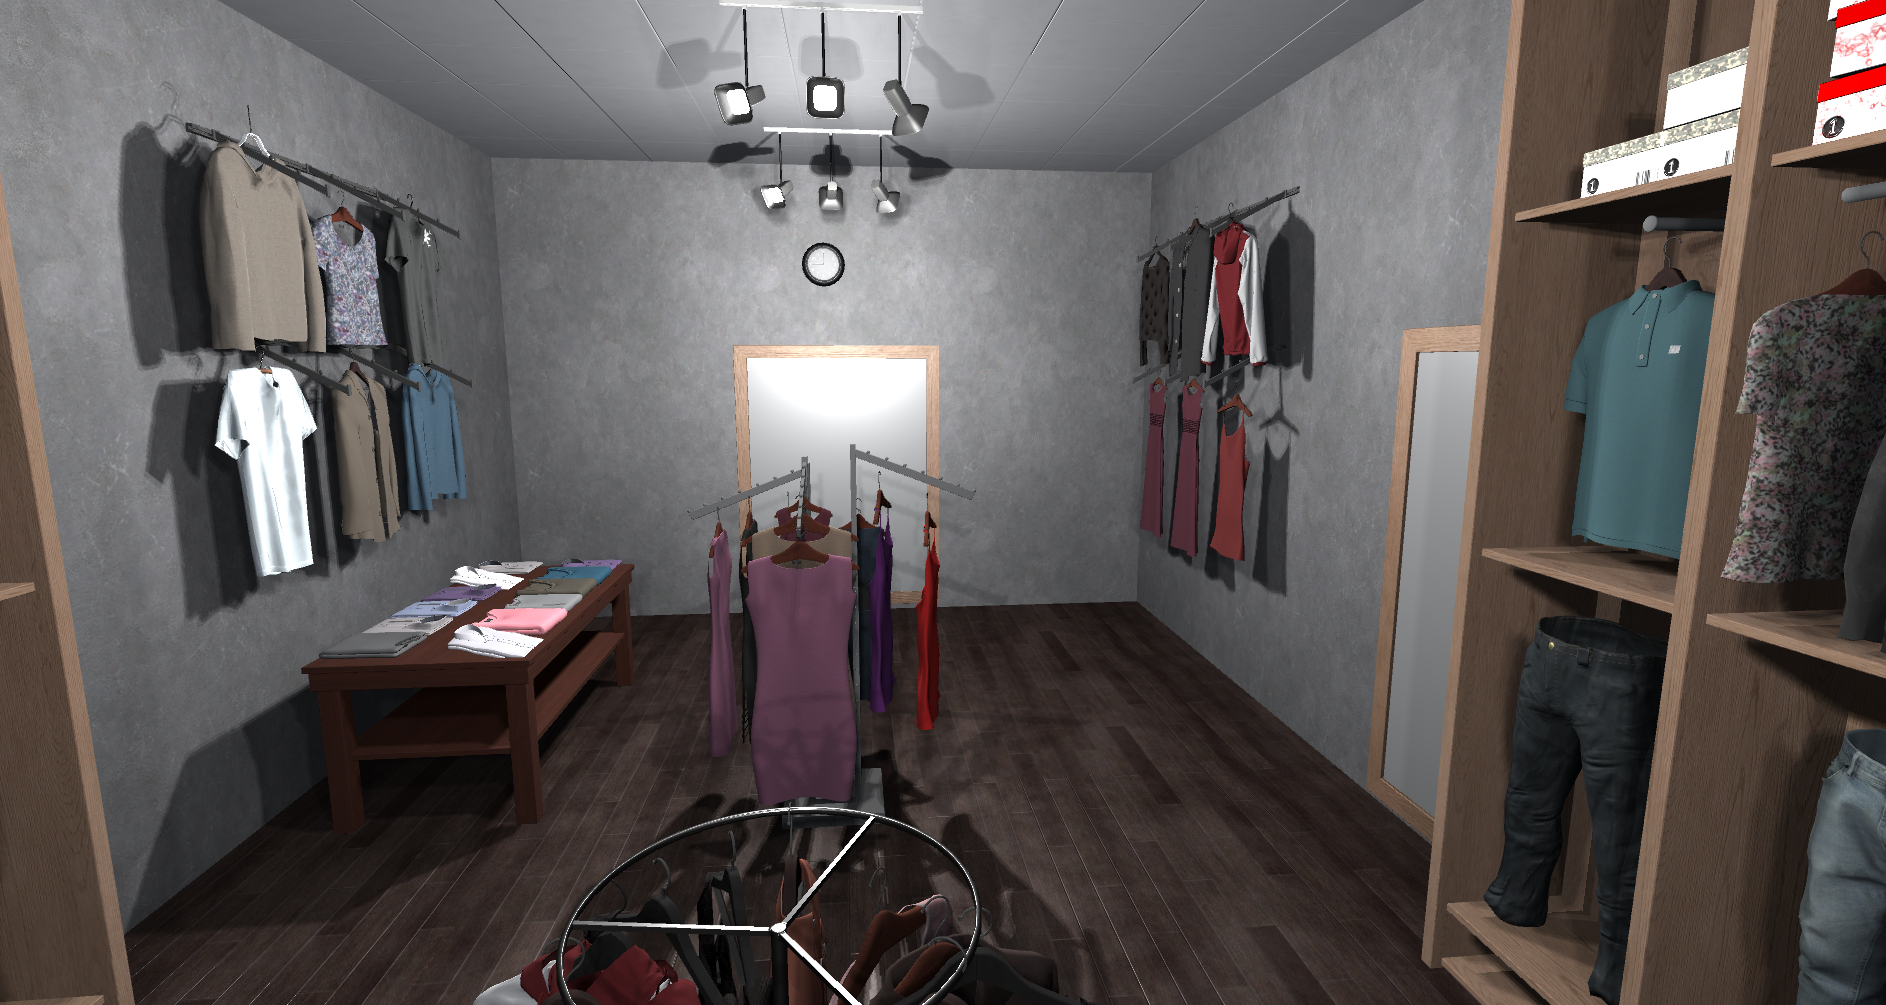

In [35]:
dataset[0]["image"]

coat


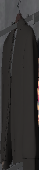

In [43]:
scene_id = 10
object_id = 1
print(MAPPING["id2cat"][dataset[scene_id]["objects"][object_id]["category_id"]])
dataset[scene_id]["image"].crop((
    dataset[scene_id]["objects"][object_id]["bbox"][0],
    dataset[scene_id]["objects"][object_id]["bbox"][1],
    dataset[scene_id]["objects"][object_id]["bbox"][0] + dataset[scene_id]["objects"][object_id]["bbox"][3],
    dataset[scene_id]["objects"][object_id]["bbox"][1] + dataset[scene_id]["objects"][object_id]["bbox"][2]))

In [17]:
def compute_image_area(example_batch):
    width, height = example_batch["image"].size
    area = width * height
    for i in range(len(example_batch["objects"])):
        example_batch["objects"][i]["area"] = area
    return example_batch

In [18]:
dataset = dataset.map(compute_image_area)

  0%|          | 0/1156 [00:00<?, ?ex/s]

In [19]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1886x1005>,
 'image_id': 0,
 'objects': [{'area': 1895430,
   'bbox': [198.0, 139.0, 212.0, 127.0],
   'category_id': 11,
   'id': 0,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [311.0, 189.0, 156.0, 76.0],
   'category_id': 6,
   'id': 1,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [384.0, 193.0, 174.0, 60.0],
   'category_id': 4,
   'id': 2,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [1167.0, 205.0, 175.0, 47.0],
   'category_id': 16,
   'id': 3,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [1200.0, 202.0, 164.0, 67.0],
   'category_id': 14,
   'id': 4,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [1139.0, 236.0, 130.0, 30.0],
   'category_id': 6,
   'id': 5,
   'iscrowd': False,
   'segmentation': []},
  {'area': 1895430,
   'bbox': [1563.0, 236.0, 320.0, 151.0],


In [20]:
raw_datasets = dataset.train_test_split(0.1)
res = raw_datasets["train"].train_test_split(0.1)
raw_datasets["train"] = res["train"]
raw_datasets["valid"] = res["test"]
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'objects'],
        num_rows: 936
    })
    test: Dataset({
        features: ['image', 'image_id', 'objects'],
        num_rows: 116
    })
    valid: Dataset({
        features: ['image', 'image_id', 'objects'],
        num_rows: 104
    })
})

In [21]:
raw_datasets["train"][100]["objects"][1]

{'area': 1658210,
 'bbox': [932.0, 18.0, 340.0, 38.0],
 'category_id': 11,
 'id': 1,
 'iscrowd': False,
 'segmentation': []}

In [22]:
feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(model_name_or_path)

In [23]:
def transform(example_batch):
    images = [image.convert("RGB") for image in example_batch["image"]]
    targets = [
        {"image_id": id_, "annotations": object_} \
        for (id_, object_) in zip(example_batch["image_id"], example_batch["objects"])
    ]
    return feature_extractor(images=images, annotations=targets, return_tensors="pt")

In [24]:
proc_datasets = deepcopy(raw_datasets)
proc_datasets["train"] = proc_datasets["train"].with_transform(transform)
proc_datasets["valid"] = proc_datasets["valid"].with_transform(transform)
proc_datasets["test"] = proc_datasets["test"].with_transform(transform)

In [25]:
proc_datasets["valid"][0]

{'pixel_values': tensor([[[-0.0801, -0.0801, -0.0801,  ..., -1.4672, -1.4329, -1.4158],
          [-0.0801, -0.0801, -0.0801,  ..., -1.3987, -1.4329, -1.4158],
          [-0.0801, -0.0801, -0.0801,  ..., -1.3815, -1.3815, -1.3815],
          ...,
          [-0.2513, -0.2513, -0.2513,  ..., -0.8335, -0.8335, -0.8335],
          [-0.2513, -0.2513, -0.2513,  ..., -0.8335, -0.8335, -0.8164],
          [-0.2342, -0.2513, -0.2513,  ..., -0.8335, -0.8335, -0.8335]],
 
         [[-0.0049, -0.0049, -0.0049,  ..., -1.5105, -1.5105, -1.4755],
          [-0.0049, -0.0049,  0.0126,  ..., -1.4580, -1.4930, -1.4930],
          [ 0.0301,  0.0126,  0.0126,  ..., -1.4405, -1.4580, -1.4755],
          ...,
          [-0.1625, -0.1625, -0.1625,  ..., -0.7577, -0.7577, -0.7577],
          [-0.1450, -0.1450, -0.1625,  ..., -0.7577, -0.7577, -0.7402],
          [-0.1450, -0.1450, -0.1625,  ..., -0.7577, -0.7577, -0.7577]],
 
         [[ 0.1651,  0.1651,  0.1651,  ..., -1.3164, -1.2990, -1.2990],
          [ 

In [26]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values, return_tensors="pt"
    )
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [27]:
model = transformers.AutoModelForObjectDetection.from_pretrained(
    model_name_or_path,
    id2label=MAPPING["id2cat"],
    label2id=MAPPING["cat2id"],
    ignore_mismatched_sizes=True)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([29, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([29]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
proc_datasets["train"] = proc_datasets["train"].shard(num_shards=50, index=0)
proc_datasets["valid"] = proc_datasets["valid"].shard(num_shards=50, index=0)

In [29]:
training_args = transformers.TrainingArguments(
    output_dir=f"./save/vis-enc/{model_name_or_path}_1e-4_bs32",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    fp16=True,
    save_strategy="epoch",
    save_steps=1,
    logging_strategy="epoch",
    logging_steps=1,
    evaluation_strategy="epoch",
    eval_steps=1,
    gradient_accumulation_steps=8,
    eval_accumulation_steps=8,
    learning_rate=1e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    report_to="tensorboard",
    seed=RANDOM_SEED,
    data_seed=RANDOM_SEED,
    load_best_model_at_end=True,
#     dataloader_num_workers=4,
    overwrite_output_dir=True,
)

In [60]:
trainer = HolyTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [62]:
train_results = trainer.train()
trainer.save_model()

/home/holy/anaconda3/envs/ambican/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 19
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 8
  Total optimization steps = 10


Epoch,Training Loss,Validation Loss
1,1.277700,5.886050


***** Running Evaluation *****
  Num examples = 3
  Batch size = 16
Saving model checkpoint to ./save/vis-enc/facebook/detr-resnet-50_1e-4_bs32/checkpoint-1
Configuration saved in ./save/vis-enc/facebook/detr-resnet-50_1e-4_bs32/checkpoint-1/config.json
Model weights saved in ./save/vis-enc/facebook/detr-resnet-50_1e-4_bs32/checkpoint-1/pytorch_model.bin
Feature extractor saved in ./save/vis-enc/facebook/detr-resnet-50_1e-4_bs32/checkpoint-1/preprocessor_config.json
Deleting older checkpoint [save/vis-enc/facebook/detr-resnet-50_1e-4_bs32/checkpoint-9] due to args.save_total_limit

KeyboardInterrupt



In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, batch in enumerate(tqdm(proc_datasets["valid"])):
    # forward pass
    outputs = model(pixel_values=batch["pixel_values"].unsqueeze(dim=0).to(device),
                          pixel_mask=batch["pixel_mask"].unsqueeze(dim=0).to(device))
    print(outputs.pred_boxes.shape, outputs.last_hidden_state)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[[0.9118, 0.7609, 0.0814, 0.2745],
         [0.5883, 0.4441, 0.0124, 0.0885],
         [0.6199, 0.8757, 0.1777, 0.2427],
         [0.6148, 0.3722, 0.0210, 0.0292],
         [0.5719, 0.3782, 0.0193, 0.0347],
         [0.6008, 0.8585, 0.1318, 0.2761],
         [0.5751, 0.4704, 0.0099, 0.1032],
         [0.5336, 0.4668, 0.0111, 0.1033],
         [0.5150, 0.3788, 0.0190, 0.0217],
         [0.5388, 0.3844, 0.0133, 0.0141],
         [0.6841, 0.8982, 0.0832, 0.1985],
         [0.9084, 0.8382, 0.1177, 0.3132],
         [0.8825, 0.8144, 0.0701, 0.1611],
         [0.8086, 0.8571, 0.0466, 0.0577],
         [0.6240, 0.9054, 0.0349, 0.1835],
         [0.6062, 0.6419, 0.6117, 0.5120],
         [0.9097, 0.3595, 0.0287, 0.0179],
         [0.7845, 0.3535, 0.0248, 0.0571],
         [0.8088, 0.8523, 0.0479, 0.0653],
         [0.7328, 0.3664, 0.0162, 0.0325],
         [0.8148, 0.9165, 0.1931, 0.1633],
         [0.7975, 0.8694, 0.0396, 0.0446],
         [0.9171, 0.3685, 0.0422, 0.0217],
         [0

tensor([[[0.0219, 0.7749, 0.0419, 0.2410],
         [0.4140, 0.5272, 0.0134, 0.2696],
         [0.2849, 0.8442, 0.0712, 0.2953],
         [0.4216, 0.5287, 0.0136, 0.2733],
         [0.3524, 0.4890, 0.0458, 0.2467],
         [0.3383, 0.6698, 0.0830, 0.6248],
         [0.3738, 0.5700, 0.0205, 0.0252],
         [0.3088, 0.7279, 0.0416, 0.1048],
         [0.2485, 0.3529, 0.0321, 0.0513],
         [0.2027, 0.5481, 0.2987, 0.4731],
         [0.6703, 0.8159, 0.0301, 0.0974],
         [0.2260, 0.6559, 0.0914, 0.6577],
         [0.7366, 0.7497, 0.1468, 0.4794],
         [0.7351, 0.7814, 0.1351, 0.4209],
         [0.3710, 0.8812, 0.0290, 0.1233],
         [0.2268, 0.5288, 0.0748, 0.3950],
         [0.2160, 0.4230, 0.0707, 0.1651],
         [0.6573, 0.5449, 0.0360, 0.0970],
         [0.6676, 0.6825, 0.0690, 0.3605],
         [0.1785, 0.5417, 0.3499, 0.5014],
         [0.7222, 0.7511, 0.1678, 0.4832],
         [0.7259, 0.7498, 0.1626, 0.4859],
         [0.0307, 0.6022, 0.0604, 0.6442],
         [0

In [52]:
outputs.pred_boxes.shape, outputs.last_hidden_state.shape

(torch.Size([1, 100, 4]), torch.Size([1, 100, 256]))

In [61]:
trainer.predict(proc_datasets["valid"])

***** Running Prediction *****
  Num examples = 3
  Batch size = 16


AttributeError: 'dict' object has no attribute 'detach'

In [38]:
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(proc_datasets["valid"], iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(proc_datasets["valid"])):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    print(outputs)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

AttributeError: 'Dataset' object has no attribute 'getImgIds'

In [ ]:
if not return_dict:
    if auxiliary_outputs is not None:
        output = (logits, pred_boxes) + auxiliary_outputs + outputs
    else:
        output = (logits, pred_boxes) + outputs
    return ((loss, loss_dict) + output) if loss is not None else output

return DetrObjectDetectionOutput(
    loss=loss,
    loss_dict=loss_dict,
    logits=logits,
    pred_boxes=pred_boxes,
    auxiliary_outputs=auxiliary_outputs,
    last_hidden_state=outputs.last_hidden_state,
    decoder_hidden_states=outputs.decoder_hidden_states,
    decoder_attentions=outputs.decoder_attentions,
    cross_attentions=outputs.cross_attentions,
    encoder_last_hidden_state=outputs.encoder_last_hidden_state,
    encoder_hidden_states=outputs.encoder_hidden_states,
    encoder_attentions=outputs.encoder_attentions,
)

In [55]:
proc_datasets["valid"][0]["labels"]["boxes"]

tensor([], size=(0, 4))

In [114]:
proc_datasets["valid"][0]

{'pixel_values': tensor([[[ 0.4851,  0.4851,  0.4851,  ...,  1.2214,  1.2214,  1.2385],
          [ 0.4851,  0.4851,  0.4851,  ...,  1.2214,  1.2385,  1.2385],
          [ 0.4851,  0.4851,  0.4851,  ...,  1.2214,  1.2385,  1.2385],
          ...,
          [-0.9363, -0.9020, -0.8335,  ..., -0.6109, -0.6109, -0.6109],
          [-0.9877, -0.9534, -0.8678,  ..., -0.6109, -0.6109, -0.6109],
          [-1.0219, -0.9877, -0.9192,  ..., -0.6109, -0.6109, -0.6109]],
 
         [[ 0.6254,  0.6254,  0.6254,  ...,  1.3782,  1.3782,  1.3957],
          [ 0.6254,  0.6254,  0.6254,  ...,  1.3782,  1.3957,  1.3957],
          [ 0.6254,  0.6254,  0.6254,  ...,  1.3782,  1.3957,  1.3957],
          ...,
          [-0.8102, -0.7752, -0.6877,  ..., -0.4951, -0.4951, -0.4951],
          [-0.8627, -0.8102, -0.7227,  ..., -0.4951, -0.4951, -0.4951],
          [-0.8978, -0.8452, -0.7577,  ..., -0.4951, -0.4951, -0.4951]],
 
         [[ 0.8448,  0.8448,  0.8448,  ...,  1.5942,  1.5942,  1.6117],
          [ 